Create Data Frame for Unemployment Statistics, Quality of Life and Cost of Living Statistics, and US City stats

In [ ]:
import pandas as pd
import ast

#Unemployment Rate
unemployment_df = pd.read_csv('city_unemployment_rate.csv')
unemployment_df_sorted = unemployment_df.sort_values(by='Unemployment Rate',ascending=False)

#Labor Force per City
labor_df = pd.read_csv('city_labor_force_population.csv')
labor_df = labor_df.sort_values(by='Labor Force Population',ascending=False)

#Quality of Life Ratings
quality_life_df = pd.read_csv('quality_of_life.csv')

#Cost of Living statistics
cost_living_df = pd.read_csv('cost_of_living.csv')

#US Cities
cities_df = pd.read_csv('uscities.csv')
city_density_df = cities_df.sort_values(by='density',ascending=False)
city_population_df = cities_df.sort_values(by='population',ascending=False)

# Function to safely convert string to tuple, used for analysis below
def str_to_tuple(val):
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError):
        return None

# Example tables to display for final report
print(cost_living_df[['City','Water (1.5 liter bottle)','Cappuccino (regular)']].head())
print(quality_life_df[['City','Purchasing Power Index','Cost of Living Index']].head())
print(unemployment_df[['City','Unemployment Rate','State Abbreviation']].head())
print(labor_df[['City','Labor Force Population']].head())


Display cities with highest purchasing power and quality of life index

In [ ]:
# Display cities with highest purchasing power and quality of life index
#Function to extract the float value from the csv file
def extract_value(val):
    t = str_to_tuple(val)
    if t and t[0] != '?':
        try:
            index_value = float(t[0])
            return index_value
        except:
            return None
    else:
        return None

#Sort the quality of life dataset by purchase power index, starting with the highest
df_purchase_power = quality_life_df.sort_values(
    by= 'Purchasing Power Index',
    key= lambda col: col.map(extract_value),
    ascending= False,
    na_position='last'
)

#Table of cities with highest purhcase power
df_purchase_power = df_purchase_power.drop_duplicates(subset=['City'], keep='first')
df_purchase_power.head(15)

Compare Monthly Apartment Prices of the Top populated US Cities

In [ ]:
import ast
import matplotlib.pyplot as plt # for additional customization

#Build a table of the 10 most populated cities and rank the cost of a 1 Bedroom apartment in the city center
cities = city_population_df[0:15]
cities_cost = dict()

for index,row in cities.iterrows():
    try:
        city = row.values[1].strip()
        city_costs= cost_living_df.loc[cost_living_df['City'] == city]
        avg_1BR_citycenter = str_to_tuple(city_costs['Apartment (1 bedroom) in City Centre'].values[0])[0]
        avg_3BR_citycenter = str_to_tuple(city_costs['Apartment (3 bedrooms) in City Centre'].values[0])[0]
        avg_1BR_non_citycenter = str_to_tuple(city_costs['Apartment (1 bedroom) Outside of Centre'].values[0])[0]
        avg_3BR_non_citycenter = str_to_tuple(city_costs['Apartment (3 bedrooms) Outside of Centre'].values[0])[0]

        #avg_meal = str_to_tuple(city_costs["Meal, Inexpensive Restaurant"].values[0])[0]
        avg_salary = str_to_tuple(city_costs['Average Monthly Net Salary (After Tax)'].values[0])[0]
        cities_cost[city] = [avg_1BR_citycenter, avg_1BR_non_citycenter, avg_3BR_non_citycenter, avg_3BR_citycenter, avg_salary]
    except:
        pass

df = pd.DataFrame(cities_cost)
df.index = ['Apartment (1 Bed) City Center','Apartment (1 Bed) Non-City Center','Apartment (3 Bed) Non-City Center','Apartment (3 Bed) City Center','Average Monthly Salary after tax']
df = df.T
df = df.map(lambda x: float(str(x).replace(',', '')))
df1 = df.sort_values(by = 'Average Monthly Salary after tax',ascending=False)

#1 Bedroom Costs 
city_1BR_costs = df1[['Apartment (1 Bed) City Center','Apartment (1 Bed) Non-City Center','Average Monthly Salary after tax']]
# Plotting a bar graph for the 'Values' column
city_1BR_costs.plot(kind='bar',figsize=(10,6))
plt.title('1BR Apartment Prices Across Major US Cities')
plt.ylabel('USD')
plt.xlabel('US Cities')
plt.xticks(rotation=45, ha='right')

#3 Bedroom costs
city_3BR_costs = df1[['Apartment (3 Bed) City Center','Apartment (3 Bed) Non-City Center','Average Monthly Salary after tax']]

# Plotting a bar graph for the 'Values' column
city_3BR_costs.plot(kind='bar',figsize=(10,6))
plt.title('3BR Apartment Prices Across Major US Cities')
plt.ylabel('USD')
plt.xlabel('US Cities')
plt.xticks(rotation=45, ha='right')



Summary Stats for Apartment Prices

In [504]:
#Summary Stats for US City Apartment Prices
df1.describe()

#use summary stats to determine on average how much more a 3 bedroom apartment costs than a 1 bedroom apartment
x = df1['Apartment (1 Bed) City Center'].mean() / df1['Apartment (1 Bed) Non-City Center'].mean() * 100 - 100
print(f'On average, 1 Bed Apartments are {round(x,1)}% more expensive in the city center than the non-city center')

x = df1['Apartment (3 Bed) City Center'].mean() / df1['Apartment (3 Bed) Non-City Center'].mean()*100 - 100
print(f'On average, 3 Bed Apartments are {round(x,1)}% more expensive in the city center than the non-city center')

x = df1['Apartment (3 Bed) City Center'].mean() / df1['Apartment (1 Bed) City Center'].mean()*100 -100
print(f'On average, 3 Bed Apartments are {round(x,1)}% more expensive than 1 Bed Apartments in the city center')

x = df1['Apartment (3 Bed) Non-City Center'].mean() / df1['Apartment (1 Bed) Non-City Center'].mean()*100 - 100
print(f'On average, 3 Bed Apartments are {round(x,1)}% more expensive than 1 Bed Apartments outside the city center')

On average, 1 Bed Apartments are 27.1% more expensive in the city center than the non-city center
On average, 3 Bed Apartments are 35.4% more expensive in the city center than the non-city center
On average, 3 Bed Apartments are 88.1% more expensive than 1 Bed Apartments in the city center
On average, 3 Bed Apartments are 76.6% more expensive than 1 Bed Apartments outside the city center


Determine if there is an obvious trend between Quality of Life VS Population of a city or Traffic/Commute vs Population

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

#Build a table of the most populated cities
cities = city_population_df
city_quality = []
cities_used = []

#Combine the uscities.csv with quality_of_life.csv to get population, density, and quality of life data into one table
for index,row in cities.iterrows():
    city = row['city']
    population = row['population']
    density = row['density']

    if city in cities_used:
        continue
    try:
        quality_life_data = quality_life_df[quality_life_df['City'] == city]
        quality_rating = float(str_to_tuple(quality_life_data['ƒQuality of Life Index:'].values[0])[0])
        traffic = float(str_to_tuple(quality_life_data['Traffic Commute Time Index'].values[0])[0])
        pollution = float(str_to_tuple(quality_life_data['Pollution Index'].values[0])[0])
        safety = float(str_to_tuple(quality_life_data['Safety Index'].values[0])[0])
        if quality_rating:
            city_quality.append((city, quality_rating, safety, traffic, pollution, population, density))
            cities_used.append(city)
    except:
        pass

#Create new data frame
df2= pd.DataFrame(city_quality,columns=['City','Quality of Life index', 'Safety Index','Traffic Commute index','Pollution Index','Population','Density'])

#Population vs Quality of Life index
df2.plot.scatter(x='Quality of Life index',y='Population')
plt.title('Population vs Quality of Life (higher is better)')
plt.show()

#Population vs Traffic/Commute index
df2.plot.scatter(x = 'Traffic Commute index', y = 'Population')
plt.title('Population vs Traffic index (lower is better)')
plt.show()

#Population vs Safety Index
df2.plot.scatter(x = 'Safety Index', y = 'Population')
plt.title('Population vs Safety Index (higher is better)')
plt.show()

#Density vs Pollution
df2.plot.scatter(x = 'Pollution Index', y = 'Density')
plt.title('Population Density vs Pollution Index (lower is better)')
plt.show()

#Density vs Population
df2.plot.scatter(x= 'Population', y='Density')
plt.title('Population vs Density')
plt.show()



In [ ]:
#Correlation
correlation = df2[['Quality of Life index','Traffic Commute index','Pollution Index','Population','Density','Safety Index']].corr()
print(correlation)


Unemployment Rate and Labor Force Population Data, Correlation

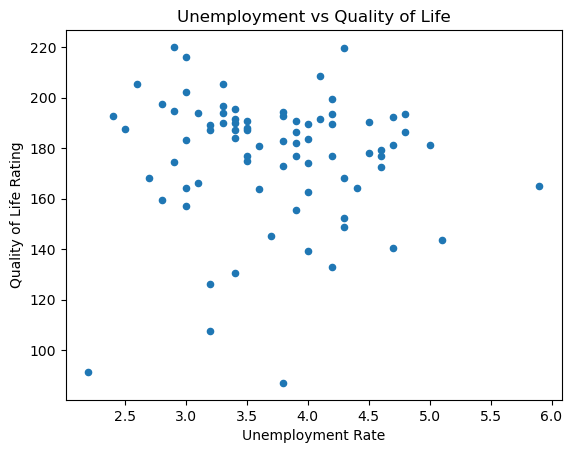

In [16]:
import re

#Unemployment Rate and Labor Force Population Data
unemployment = []
unemployment_quality = []
cities_found = []

for index,row in labor_df.iterrows():
    population = row['Labor Force Population']
    city = row['City']
    state = row['State Abbreviation']
    try:
        data = unemployment_df[unemployment_df['City'] == city]
        unemployment_rate = data['Unemployment Rate'].values[0]
        unemployment.append((city,state,population,unemployment_rate))
    except:    
        pass

for city,state,population,unemployment_rate in unemployment:
    cities = city.split('-')
    pattern = r'\b(county|city|town|township|plantation|unorganized)\b'
    for city in cities:
        city = re.sub(pattern,'',city,flags=re.IGNORECASE)
        if city in cities_found:
            continue
        try:
            quality_life_data = quality_life_df[quality_life_df['City'] == city]
            quality_rating = float(str_to_tuple(quality_life_data['ƒQuality of Life Index:'].values[0])[0])
            unemployment_quality.append((city,state,population,unemployment_rate,quality_rating))

            cities_found.append(city)
        except:
            pass

df4 = pd.DataFrame(unemployment_quality, columns = ['City','State','Population','Unemployment Rate','Quality of Life Rating'])

#Population vs Quality of Life index
df4.plot.scatter(x='Unemployment Rate',y='Quality of Life Rating')
plt.title('Unemployment vs Quality of Life')
plt.show()

In [19]:
df4 = pd.DataFrame(unemployment_quality, columns = ['City','State','Population','Unemployment Rate','Quality of Life Rating'])
df4[['Population','Unemployment Rate','Quality of Life Rating']].corr()


,Population,Unemployment Rate,Quality of Life Rating
Population,1.000000,0.167743,-0.198817
Unemployment Rate,0.167743,1.000000,-0.042383
Quality of Life Rating,-0.198817,-0.042383,1.000000
